In [56]:
import torch.nn as nn
from torch_geometric.nn import GCNConv, GATConv, BatchNorm
# load co-occurrence graph
import torch
import torch.optim as optim


class CoOccurrenceGNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, activation=nn.ReLU):
        """
        GNN for learning ingredient embeddings from co-occurrence graphs.

        Parameters:
        - input_dim: Dimensionality of input node features.
        - hidden_dim: Dimensionality of hidden layers.
        - output_dim: Dimensionality of output node embeddings.
        """
        super(CoOccurrenceGNN, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, output_dim)
        self.activation = activation()

    def forward(self, x, edge_index, edge_attr=None):
        """
        Forward pass for the GNN.

        Parameters:
        - x: Node features (num_nodes, input_dim).
        - edge_index: Graph connectivity (2, num_edges).
        - edge_attr: Edge weights (num_edges).

        Returns:
        - Node embeddings (num_nodes, output_dim).
        """
        
        
        # First GCN layer
        x = self.conv1(x, edge_index, edge_weight=edge_attr)
        x = self.activation(x)

        # Second GCN layer
        x = self.conv2(x, edge_index, edge_weight=edge_attr)
        return x
    
class CoOccurrenceGNNV2(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, edge_dim, activation=nn.ReLU, dropout_rate=0.3):
        """
        Improved GNN for learning embeddings from co-occurrence graphs.

        Parameters:
        - input_dim: Dimensionality of input node features.
        - hidden_dim: Dimensionality of hidden layers.
        - output_dim: Dimensionality of output embeddings.
        - edge_dim: Dimensionality of edge attributes.
        - activation: Activation function to use (default: ReLU).
        - dropout_rate: Dropout rate to apply (default: 0.3).
        """
        super(CoOccurrenceGNNV2, self).__init__()
        
        # Graph Attention Layers
        self.conv1 = GATConv(input_dim, hidden_dim, edge_dim=edge_dim)
        self.conv2 = GATConv(hidden_dim, output_dim, edge_dim=edge_dim)
        
        # Batch Normalization
        self.bn1 = BatchNorm(hidden_dim)
        self.bn2 = BatchNorm(output_dim)
        
        # Activation
        self.activation = activation()
        
        # Dropout for regularization
        self.dropout = nn.Dropout(dropout_rate)
        
        # Residual connection
        self.residual = input_dim == output_dim  # Add residual connection only if dimensions match

    def forward(self, x, edge_index, edge_attr):
        """
        Forward pass for the GNN.
        """
        # First GAT Layer
        x1 = self.conv1(x, edge_index, edge_attr=edge_attr)
        x1 = self.bn1(x1)
        x1 = self.activation(x1)
        x1 = self.dropout(x1)
        
        # Second GAT Layer
        x2 = self.conv2(x1, edge_index, edge_attr=edge_attr)
        x2 = self.bn2(x2)
        
        # Residual connection (if applicable)
        if self.residual:
            x2 = x2 + x

        return x2


In [57]:
def train_gnn(model, graph, epochs=50, learning_rate=0.01, weight_decay=1e-5):
    """
    Train the GNN on the co-occurrence graph.

    Parameters:
    - model: GNN model.
    - graph: PyTorch Geometric graph object.
    - epochs: Number of training epochs.
    - learning_rate: Learning rate for the optimizer.

    Returns:
    - model: Trained GNN model.
    """
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    loss_fn = nn.MSELoss()

    # Move model and graph to the same device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    graph = graph.to(device)

    # Log graph properties
    print("Graph Properties:")
    print(f"  Number of Nodes: {graph.x.shape}")
    print(f"  Number of Edges: {graph.edge_index.shape}")
    print(f"  Edge Attribute Dim: {graph.edge_attr.shape}")

    for epoch in range(1, epochs + 1):
        model.train()
        optimizer.zero_grad()

        # Forward pass
        out = model(graph.x, graph.edge_index, edge_attr=graph.edge_attr)

        # Compute edge prediction loss
        edge_attr_pred = (out[graph.edge_index[0]] * out[graph.edge_index[1]]).sum(dim=1)
        loss = loss_fn(edge_attr_pred, graph.edge_attr)

        # Backpropagation and optimization
        loss.backward()
        optimizer.step()

        # Log progress
        if epoch % 5 == 0 or epoch == epochs:
            print(f"Epoch {epoch}/{epochs}, Loss: {loss.item():.4f}")

    print("Training Complete!")
    return model

In [58]:
# load co-occurrence graph
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

graph = torch.load("../utils/data/ingredient_graph.pt", weights_only=False, map_location=device)
graph


Data(x=[199, 199], edge_index=[2, 5864], edge_attr=[5864])

In [59]:
# Define the GNN model
input_dim = graph.x.size(1)  # Number of input features
hidden_dim = 128
output_dim = 128

edge_dim = graph.edge_attr.size(1) if graph.edge_attr is not None and graph.edge_attr.dim() > 1 else 1

# model = CoOccurrenceGNN(input_dim, hidden_dim, output_dim)
model = CoOccurrenceGNNV2(input_dim, hidden_dim, output_dim, edge_dim)

model = model.to(device)
# Train the GNN
model = train_gnn(model, graph, epochs=75)


Graph Properties:
  Number of Nodes: torch.Size([199, 199])
  Number of Edges: torch.Size([2, 5864])
  Edge Attribute Dim: torch.Size([5864])
Epoch 5/75, Loss: 5.4606
Epoch 10/75, Loss: 1.6752
Epoch 15/75, Loss: 0.4966
Epoch 20/75, Loss: 0.3307
Epoch 25/75, Loss: 0.1772
Epoch 30/75, Loss: 0.1012
Epoch 35/75, Loss: 0.0573
Epoch 40/75, Loss: 0.0635
Epoch 45/75, Loss: 0.0418
Epoch 50/75, Loss: 0.0518
Epoch 55/75, Loss: 0.0378
Epoch 60/75, Loss: 0.0366
Epoch 65/75, Loss: 0.0283
Epoch 70/75, Loss: 0.0279
Epoch 75/75, Loss: 0.0299
Training Complete!


In [60]:
# Put the model in evaluation mode
model.eval()

# Perform a forward pass to get the ingredient embeddings
with torch.no_grad():
    ingredient_embeddings = model(graph.x, graph.edge_index, graph.edge_attr)

ingredient_embeddings.shape

torch.Size([199, 128])

In [61]:
import torch.nn.functional as F
train_ingr_id = '../utils/data/train_labels_ingr_id.csv'
# val_ingr_id = './val_labels_ingr_id.csv'
# test_ingr_id = './test_labels_ingr_id.csv'
import pandas as pd

train_df = pd.read_csv(train_ingr_id)
# ingredients name = train_df's columns name
ingredients = train_df.columns[1:-1].to_list()

# Normalize embeddings for cosine similarity
normalized_embeddings = F.normalize(ingredient_embeddings, p=2, dim=1)

# Compute pairwise similarity
similarity_matrix = normalized_embeddings @ normalized_embeddings.t()

# Find top-5 similar ingredients for a specific ingredient (e.g., ingredient 0)
ingredient_index = 0
top_k = 5
similar_indices = torch.topk(similarity_matrix[ingredient_index], top_k + 1).indices[1:]  # Exclude self
print(f"Top-{top_k} similar ingredients for ingredient {ingredient_index}: {similar_indices}")

# Print the top-5 similar ingredients
ingredient_0 = ingredients[ingredient_index]
similar_ingredients = [ingredients[i] for i in similar_indices]
print(f"Ingredient: {ingredient_0}")
print(f"Similar Ingredients: {similar_ingredients}")


Top-5 similar ingredients for ingredient 0: tensor([65, 50, 23, 84, 74])
Ingredient: brown rice
Similar Ingredients: ['white rice', 'jalapenos', 'chard', 'bok choy', 'cheese pizza']


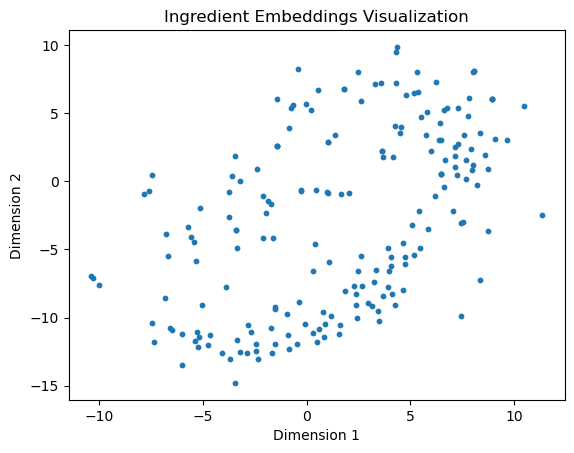

In [62]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Reduce dimensions with t-SNE
reduced_embeddings = TSNE(n_components=2, random_state=42).fit_transform(ingredient_embeddings.numpy())

# Plot the embeddings
plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], s=10)
plt.title("Ingredient Embeddings Visualization")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.show()


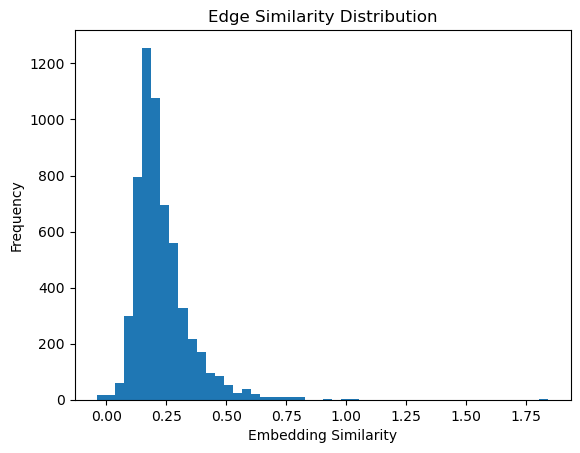

In [63]:
edge_similarity = (ingredient_embeddings[graph.edge_index[0]] * ingredient_embeddings[graph.edge_index[1]]).sum(dim=1)
plt.hist(edge_similarity.numpy(), bins=50)
plt.title("Edge Similarity Distribution")
plt.xlabel("Embedding Similarity")
plt.ylabel("Frequency")
plt.show()


In [ ]:
# Save the ingredient embeddings
torch.save(ingredient_embeddings, "../utils/data/ingredient_embeddings_gnn_gat_test.pt")